In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG']**

In [8]:
import yfinance as yf
stock_symbol = 'FB'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-17,201.699997,208.039993,201.110001,207.839996,207.839996,29499700
501,2022-03-18,206.699997,216.800003,206.000000,216.490005,216.490005,52055000
502,2022-03-21,214.500000,214.710007,207.630005,211.490005,211.490005,30142300
503,2022-03-22,211.369995,219.460007,210.179993,216.649994,216.649994,31998800
504,2022-03-23,213.330002,216.800003,212.160004,213.460007,213.460007,23698400


#### Visualizing the Real Stock Trend

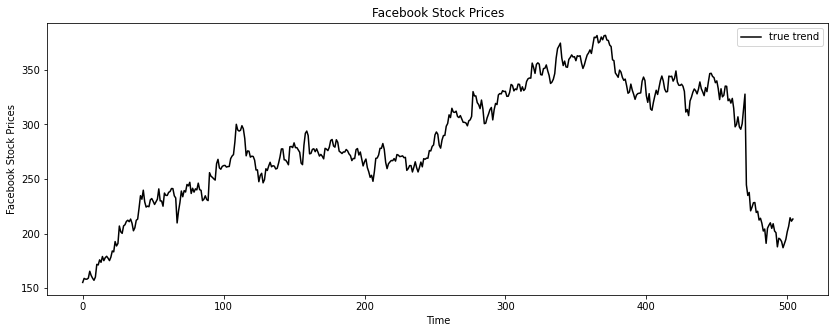

In [9]:
plt.figure(figsize=(14,5))
plt.plot(data['Open'],color='black',label='true trend')
plt.title('Facebook Stock Prices')
plt.xlabel('Time')
plt.ylabel('Facebook Stock Prices')
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [10]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [11]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,155.210007,161.309998,152.570007,160.979996,30440400
1,158.919998,162.990005,153.059998,156.210007,35184300
2,158.250000,164.000000,157.020004,163.339996,26556800
3,158.199997,160.089996,154.750000,156.789993,24879900
4,159.179993,166.750000,158.059998,165.949997,22515200


In [12]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.        , 0.01501632, 0.00763227, 0.02982457, 0.34086376])

In [13]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 31st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((385, 60, 5), (385,))

#### Preparaing testing data

In [16]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
            Open        High         Low       Close    Volume
 385  341.609985  345.019989  338.640015  343.010010  14905300
 386  335.529999  335.940002  322.700012  326.230011  42885000
 387  328.579987  335.179993  326.160004  332.959991  35377900
 388  329.739990  334.380005  325.799988  333.640015  26443000
 389  337.000000  338.839996  328.980011  329.220001  28307500)

In [ ]:
df = scaler.transform(df)
df[0]

In [ ]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

#### Defining the Scaling Label

In [ ]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

In [ ]:
scale = 1/8.50296711e-04
scale

In [ ]:
y_test = y_test*scale

#### RNN - Recurrent Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
x_train.shape[1],x_train.shape[2]

In [ ]:
model = Sequential()

# 1st layer
model.add(LSTM(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

# 2nd layer
model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.2))

# 3rd layer
model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.2))

# Final layer
model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary()

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [ ]:
result_forecast = []
simulation = 1
for i in range(simulation):
    print("Simulation %d"%i)
    result_forecast.append(forecast())

#### Calculating the Accuracy using RMSE

In [ ]:
# RMSE - Root Mean Squared Error 
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = np.sqrt(np.mean(np.square(predict-real)))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

#### Visualization

In [ ]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Facebook Stock Prices - Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('Facebook Stock Prices')
plt.legend()
plt.show()